# Regresión Simple con tensorflow, Pandas y el dataset Auto MPG

Se utilizará el dataset clásico conocido como [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y se construirá un modelo para predecir la eficiencia de vehículos de los años de 1970 a 1980 (rango de años de los que contiene datos el dataset en cuestión). Entre los atributos que usaremos estarán los cilindros, desplazamiento, potencia y peso del automóvil.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


# El Dataset Auto MPG

Este dataset está disponible en el repositorio de [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

## Obtenemos los datos usando Keras para traerlo del repositorio.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

/root/.keras/datasets/auto-mpg.data


## Usamos pandas para importarlo

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
print(dataset["Horsepower"])

0      130.0
1      165.0
2      150.0
3      150.0
4      140.0
       ...  
393     86.0
394     52.0
395     84.0
396     79.0
397     82.0
Name: Horsepower, Length: 398, dtype: float64


## Pre-procesamos los datos

Revisamos si hay valores desconocidos en los datos.

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Eliminados las filas que contienen valores desconocidos

In [ ]:
dataset = dataset.dropna()

La columna "Origin" no es numérica, la convertiremos a valores de 0 o 1, usando lo que se conoce en este ámbito como "one-hot":

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Separemos los datos en entrenamiento y prueba.

El conjunto de datos de prueba lo usaremos para evaluar nuestro modelo.

In [ ]:
# dataset de entrenamiento
train_dataset = dataset.sample(frac=0.8,random_state=0)

In [ ]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,28.0,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,22.3,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,12.0,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,38.0,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,33.8,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,16.0,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,26.0,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0


In [ ]:
train_dataset.index

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)

In [ ]:
# dataset de prueba, del original eliminamos todos los elementos del dataset de entrenamiento
test_dataset = dataset.drop(train_dataset.index)

## Revisamos los datos

Revisamos la distribución conjunta de un par de columna del conjunto de datos de entrenamiento

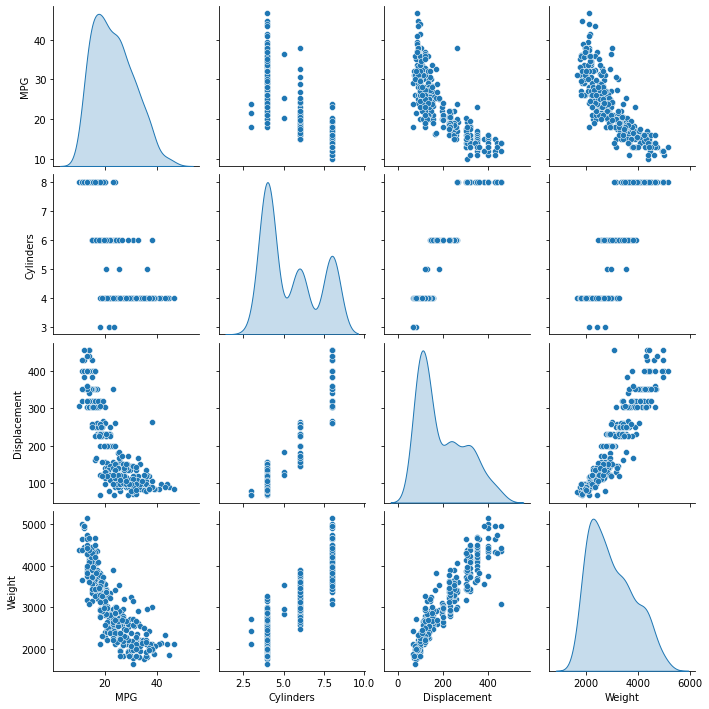

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Revisamos las estadísticas generales

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Separamos las características de las etiquetas

Los valores de las etiquetas será lo que el modelo buscará predecir.

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
print(train_labels)

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64


## Normalizamos los datos

Si observamos los datos de las diferentes características en las estadísticas más arriba podemos observar que se manejan rangos muy diferentes en cada una de ellas.

Es común y además buena práctica normalizar los datos para facilitar el entrenamiento.

**Nota:** Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [ ]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Definimos el modelo

Aquí, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, build_model, ya que crearemos un segundo modelo, más adelante.

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

## Revisamos el modelo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Probando el modelo

Tomaremos un lote de 10 ejemplos de los datos de entrenamiento y llamaremos a `model.predict` con dicho lote.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.19450791],
       [-0.19728553],
       [-0.3864546 ],
       [-0.32597232],
       [-0.4918404 ],
       [-0.19075188],
       [-0.53445816],
       [-0.81988543],
       [-0.24339798],
       [-0.17197561]], dtype=float32)

## Entrenamos al modelo

Entrenaremos al modelo por 1000 épocas, guardaremos los resultados de precisón del entrenamiento y validación en el objeto `history`.

In [ ]:
# Desplegamos el progreso del entrenamiento imprimiento un punto por cada época completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Visualicemos el progreso del entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.647949,1.033622,2.647949,10.293451,2.443176,10.293451,995
996,2.702276,1.017542,2.702276,10.002641,2.392659,10.002641,996
997,2.613332,0.988384,2.613332,10.257855,2.419743,10.257855,997
998,2.487201,0.962266,2.487201,10.390724,2.442982,10.390724,998
999,2.652633,1.012817,2.652633,10.039091,2.432439,10.039091,999


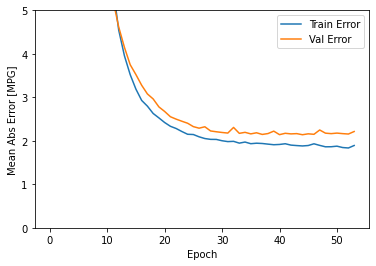

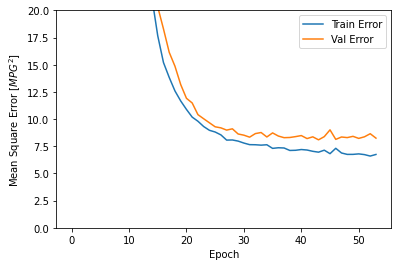

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una **devolución de llamada de EarlyStopping** que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada [aquí](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


......................................................

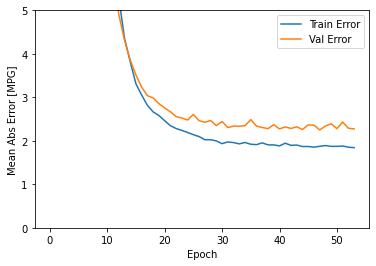

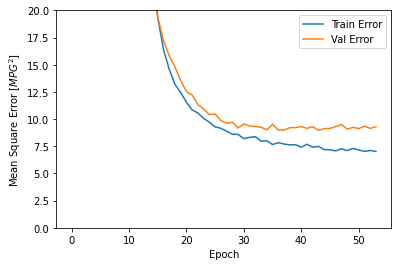

In [ ]:
model = build_model()

# El parámetro "patience" es la cantidad de épocas que se revisará por una mejora, si la mejora no ocurre se detiene el proceso.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Esto siempre dependerá de ustedes y de lo que consideren aceptable.

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.5811 - mae: 1.7958 - mse: 5.5811
Testing set Mean Abs Error:  1.80 MPG


## Hagamos predicciones

Usaremos los datos del conjunto de pruebas para predecir los valores de MPG.

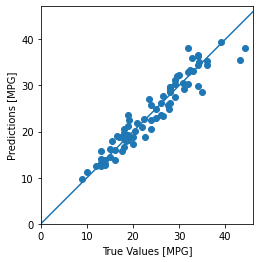

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

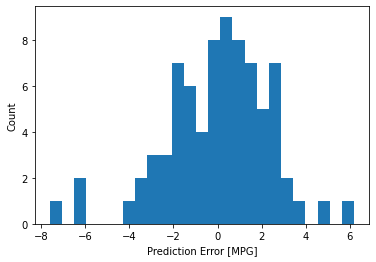

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano (curva de campana de la distribución normal), pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusiones

Este bloc de notas introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.

Basado en la documentación de Tensorflow, disponible en: https://www.tensorflow.org/tutorials/keras/regression

In [ ]:
#@title MIT License
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.